In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
exp_data_path = '/content/drive/MyDrive/FYP_Data/FinalData/CleanedData.csv'
inter_data_path = '/content/drive/MyDrive/FYP_Data/FinalData/InterpolatedData.csv'

Loading Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

def tf_cast(x):
    return tf.cast(x, tf.float32)

In [30]:
exp_data = pd.read_csv(exp_data_path)
inter_data = pd.read_csv(inter_data_path)

print(exp_data.columns)
inter_data.head(5)

Index(['helical_angle', 'helical_layer_count', 'hoop_layer_count',
       'bust_pressure', 'tensile_str', 'e1_gpa', 'youngs_modulus',
       'poision_ratio', 'yeild_strength', 'ult_tensile_strength',
       'liner_thickness', 'diameter', 'doily_layers'],
      dtype='object')


,helical_angle,helical_layer_count,hoop_layer_count,tensile_str,e1_gpa,youngs_modulus,poision_ratio,yeild_strength,ult_tensile_strength,liner_thickness,diameter,doily_layers,bust_pressure
0,12.0,14.0,3.0,830.0,37.0,138.0,0.30,231.0,342.0,0.55,147.0,10.0,992.41
1,42.0,16.0,1.0,711.0,45.0,138.0,0.27,234.0,342.0,0.56,149.0,4.0,989.93
2,12.0,6.0,8.0,922.0,104.0,102.0,0.31,246.0,317.0,0.63,152.0,7.0,992.15
3,43.0,7.0,7.0,950.0,47.0,89.0,0.28,238.0,313.0,0.26,164.0,12.0,994.02
4,44.0,12.0,11.0,878.0,97.0,70.0,0.29,242.0,340.0,0.51,126.0,17.0,995.50


In [31]:
input_cols = ['bust_pressure',  'tensile_str', 'e1_gpa', 'youngs_modulus', 'poision_ratio', 'yeild_strength', 'diameter', 'ult_tensile_strength']
output_cols = ['helical_angle', 'helical_layer_count', 'hoop_layer_count', 'liner_thickness', 'doily_layers']

In [32]:
exp_data_inp = exp_data[input_cols]
exp_data_out = exp_data[output_cols]
inter_data_inp = inter_data[input_cols]
inter_data_out = inter_data[output_cols]

In [33]:
x_train_exp, x_test_exp, y_train_exp, y_test_exp = train_test_split(exp_data_inp, exp_data_out, test_size=0.25, random_state=42)
x_train_inter, x_test_inter, y_train_inter, y_test_inter = train_test_split(inter_data_inp, inter_data_out, test_size=0.25, random_state=42)

x_val_exp, x_test_exp, y_val_exp, y_test_exp = train_test_split(x_test_exp, y_test_exp, train_size=0.6, random_state=49)
x_val_inter, x_test_inter, y_val_inter, y_test_inter = train_test_split(x_test_inter, y_test_inter, train_size=0.6, random_state=49)

In [34]:
x_train_exp.shape, x_val_exp.shape, x_test_exp.shape, x_train_inter.shape, x_val_inter.shape, x_test_inter.shape

((32, 8), (6, 8), (5, 8), (337, 8), (67, 8), (46, 8))

In [35]:
x_train = pd.concat([x_train_exp, x_train_inter], axis=0)
y_train = pd.concat([y_train_exp, y_train_inter], axis=0)
x_val = pd.concat([x_val_exp, x_val_inter], axis=0)
y_val = pd.concat([y_val_exp, y_val_inter], axis=0)
x_test = pd.concat([x_test_exp, x_test_inter], axis=0)
y_test = pd.concat([y_test_exp, y_test_inter], axis=0)

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((369, 8), (73, 8), (51, 8), (369, 5), (73, 5), (51, 5))

In [36]:
# Scaling - y
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

In [37]:
def inverse_scale(scaled_data, as_tensor=False, scaler=y_scaler):
    if as_tensor:
        # build tf constants matching the scaler
        scale = tf.constant(scaler.scale_, dtype=tf.float32)
        mean = tf.constant(scaler.mean_, dtype=tf.float32)
        # (batch_size, dims) * (dims,) + (dims,) → (batch_size, dims)
        return scaled_data * scale + mean
    else:
        # fallback to numpy inverse
        return scaler.inverse_transform(scaled_data)

## Making Model

Skipping the above steps = Redefing the models

In [38]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

input_dim, output_dim

(8, 5)

In [39]:
def build_model():
    input_layer = Input(shape=(input_dim,), name='input_layer')

    x = Dense(48, name='hidden_layer_1', activation='sigmoid')(input_layer)
    x = Dense(128, name='hidden_layer_2', activation='sigmoid')(x)
    # x = Dense(64, name='hidden_layer_3', activation='sigmoid')(x)
    x = Dense(32, name='hidden_layer_4', activation='sigmoid')(x)

    output_layer = Dense(output_dim, activation='linear', name='output_layer')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = build_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 48)             │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,997 (42.96 KB)

 Trainable params: 10,997 (42.96 KB)

 Non-trainable params: 0 (0.00 B)

Defining Loss

In [40]:
# These are the assumed layer thicknesses used in the experiment
layer_thickness_hoop = tf.constant(0.2)
layer_thickness_helical = tf.constant(0.45)
layer_thickness_doily = tf.constant(0.5)

In [41]:
def physics_loss(x_input, y_pred):
    # Cast all inputs to float32 (or match your model's dtype)
    x_input = tf_cast(inverse_scale(x_input, as_tensor = True, scaler=x_scaler))
    y_pred = tf_cast(inverse_scale(y_pred, as_tensor = True))

    # Access features using indices
    diameter = x_input[:, input_cols.index('diameter')]
    liner_thickness = y_pred[:, output_cols.index('liner_thickness')]
    sigma_liner = x_input[:, input_cols.index('ult_tensile_strength')]
    n_hoop = y_pred[:, output_cols.index('hoop_layer_count')]
    sigma_cf = x_input[:, input_cols.index('tensile_str')]
    n_helical = y_pred[:, output_cols.index('helical_layer_count')]
    helical_angle = y_pred[:, output_cols.index('helical_angle')]
    n_doily = y_pred[:, output_cols.index('doily_layers')]
    input_brust_pressure = x_input[:, input_cols.index('bust_pressure')]


    liner_pressure = liner_thickness * sigma_liner
    hoop_pressure = layer_thickness_hoop * sigma_cf * n_hoop
    helical_pressure = layer_thickness_helical * sigma_cf * n_helical * (tf.cos(tf.cast(helical_angle * np.pi / 180.0, tf.float32)) ** 2)
    doily_pressure = layer_thickness_doily * sigma_cf * n_doily

    burst_pressure = 2 * (liner_pressure + hoop_pressure + helical_pressure + doily_pressure) / diameter

    loss = tf.reduce_mean(tf.abs(burst_pressure - input_brust_pressure))
    return loss

def data_loss(y_true, y_pred):
    # y_pred = inverse_scale(y_pred, as_tensor = True)
    # y_ture = inverse_scale(y_true, as_tensor = True)
    loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return loss

def loss_function(x_input, y_true, y_pred, physics_loss_factor=0.2):
    return data_loss(y_true, y_pred) + physics_loss_factor * physics_loss(x_input, y_pred)

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
epochs = 100
best_val_loss = float('inf')
batch_size = 8

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_scaled)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val_scaled)).batch(batch_size)

In [44]:
def train_step(x_batch, y_batch):
    x_batch = tf.cast(x_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)

    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        loss = loss_function(x_batch, y_batch, y_pred)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def validate_step(x_batch, y_batch):
    x_batch = tf.cast(x_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)

    y_pred = model(x_batch, training=False)
    return loss_function(x_batch, y_batch, y_pred)

In [45]:
def tf_r2score(y_true, y_pred):
    y_pred = inverse_scale(y_pred, as_tensor=True)
    y_true = inverse_scale(y_true, as_tensor=True)
    total_error = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    unexplained_error = tf.reduce_sum(tf.square(y_true - y_pred))
    return 1.0 - (unexplained_error / (total_error + 1e-7))

In [46]:
%%time

history = {
    'train_loss' : [],
    'val_loss' : [],
    'r2_score' : []
}
for epoch in range(epochs):
    # Training
    train_loss = []
    for x_batch, y_batch in train_dataset:
        loss = train_step(x_batch, y_batch)
        train_loss.append(loss)

    # Validation
    val_loss = []
    for x_batch, y_batch in val_dataset:
        loss = validate_step(x_batch, y_batch)
        val_loss.append(loss)

    # Calculate epoch metrics
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)

    y_val_pred = model.predict(x_val_scaled)
    val_r2s = tf_r2score(y_val_scaled, y_val_pred).numpy()

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['r2_score'].append(val_r2s)

    # Early stopping checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_weights("best_model.weights.h5")

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Val R2 Score: {val_r2s :.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/100
Train Loss: 110.195, Val Loss: 72.692, Val R2 Score: -5.425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 2/100
Train Loss: 52.061, Val Loss: 49.952, Val R2 Score: -11.107
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 3/100
Train Loss: 46.825, Val Loss: 49.796, Val R2 Score: -10.971
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 4/100
Train Loss: 46.887, Val Loss: 49.714, Val R2 Score: -11.035
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 5/100
Train Loss: 46.821, Val Loss: 49.650, Val R2 Score: -11.006
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 6/100
Train Loss: 46.774, Val Loss: 49.585, Val R2 Score: -10.995
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 7/100
Train Loss: 46.720, Val Loss: 49.519, Val R2 Score: -10.994
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 8/100
Train Loss: 46.678, Val Loss: 49.360, Val R2 Score: -11.137
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 9/100
Train Loss: 46.578, Val Loss: 49.379, Val R2 Score: -11.016
3/3 ━━━━━━

In [47]:
import joblib

# Export the scalers to files
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')

joblib.dump(model, 'final_model.pkl')

['final_model.pkl']

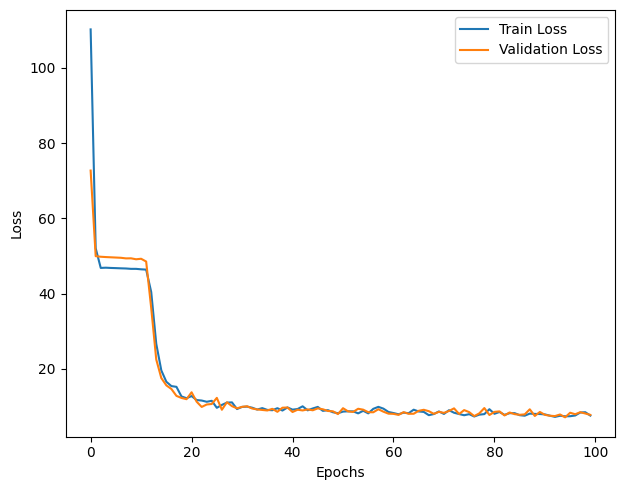

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history['r2_score'], label='Validation R2 Score')
# plt.xlabel('Epochs')
# plt.ylabel('R2 Score')
# plt.legend()

plt.tight_layout()
plt.show()

Predicting the test values

In [49]:
y_test_pred = model.predict(x_test_scaled)
y_test_pred = inverse_scale(y_test_pred, as_tensor=True)
pd.DataFrame(y_test_pred, columns = output_cols).tail()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,helical_angle,helical_layer_count,hoop_layer_count,liner_thickness,doily_layers
46,14.627623,27.200157,10.186113,0.601468,93.566452
47,13.479820,29.747778,10.387486,0.613560,98.767563
48,8.400570,51.389702,11.365715,0.486248,139.754120
49,15.277431,23.418179,10.031647,0.586239,85.076675
50,5.225872,59.983360,10.752701,0.686393,150.824768


In [50]:
pd.DataFrame(y_test, columns = output_cols).tail()

,helical_angle,helical_layer_count,hoop_layer_count,liner_thickness,doily_layers
249,40.0,2.0,11.0,0.70,15.0
305,39.0,2.0,2.0,0.72,7.0
82,19.0,10.0,7.0,0.44,8.0
56,32.0,9.0,8.0,0.66,16.0
25,44.0,9.0,11.0,0.49,15.0


There is huge difference in the Results

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(true, pred):
    true = true.to_numpy()
    pred = pred.numpy()
    ret = {}
    ret['MAE'] = mean_absolute_error(true, pred)
    ret['MSE'] = mean_squared_error(true, pred)
    ret['RMSE'] = np.sqrt(ret['MSE']).item()
    ret['R2S'] = r2_score(true, pred)
    return ret

In [26]:
# exp train
y_train_exp_pred = model.predict(x_scaler.transform(x_train_exp))
y_train_exp_pred = inverse_scale(y_train_exp_pred, as_tensor=True)

evaluate(y_train_exp, y_train_exp_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


{'MAE': 25.768129612877964,
 'MSE': 2850.4580986238093,
 'RMSE': 53.38968157447476,
 'R2S': -127.9636105690455}

In [27]:
def get_pred_scores(inp, target):
    inp_scaled = x_scaler.transform(inp)
    pred = model.predict(inp_scaled)
    pred = inverse_scale(pred, as_tensor=True)
    return evaluate(target, pred)

Checking the score of all the datasets

In [28]:
print(get_pred_scores(x_train_exp, y_train_exp))
print(get_pred_scores(x_train_inter, y_train_inter))

print(get_pred_scores(x_val_exp, y_val_exp))
print(get_pred_scores(x_val_inter, y_val_inter))

print(get_pred_scores(x_test_exp, y_test_exp))
print(get_pred_scores(x_test_inter, y_test_inter))

print("\n\n\n\nCombined : ")
print(get_pred_scores(x_train, y_train))
print(get_pred_scores(x_val, y_val))
print(get_pred_scores(x_test, y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
{'MAE': 25.768129612877964, 'MSE': 2850.4580986238093, 'RMSE': 53.38968157447476, 'R2S': -127.9636105690455}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
{'MAE': 32.8188149182471, 'MSE': 4201.230220275395, 'RMSE': 64.81689764463735, 'R2S': -133.44322616211053}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
{'MAE': 26.184267610311508, 'MSE': 3313.1210706096326, 'RMSE': 57.55971742989738, 'R2S': -136.5725319389337}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
{'MAE': 32.798468466374416, 'MSE': 4155.860767128341, 'RMSE': 64.46596595978642, 'R2S': -156.31083625510902}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
{'MAE': 25.55446615219116, 'MSE': 2924.4631595348574, 'RMSE': 54.078305812357485, 'R2S': -259.5052037699055}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
{'MAE': 32.94422040072213, 'MSE': 4117.491232450482, 'RMSE': 64.16768059117052, 'R2S': -153.1243110388469}




Combined : 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
{'MAE': 32.20737337415005, 'MSE': 4084.090090484471, 'RMSE': 63.